In [1]:
import numpy as np
import pandas as pd
import random
import time
import copy
import math
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

Rules:
1. Double round robin (A at B and B at A): n teams need 2*n-2 slots.

2. No more than three consecutive home or three consecutive road games for any team; the "unconstrained" entries remove this restriction

3. No repeaters (A at B, followed immediately by B at A)

4. Objective is to minimize distance traveled (assume teams begin in their home city and must return there after the tournament)


Let's start with 6 teams first. (Best solution: 23916)

In [3]:
#Distance matrix
distance_matrix= pd.read_csv("Distance_Matrix_6.txt",delimiter="\t",header=None)
n=distance_matrix.shape[0]

In [4]:
#Input a string like '@1' or '1' to return 1
def purify(x):
    if x[0]=='@':
        return int(x[1:])
    else:
        return int(x)

In [5]:
#Randomly generate an initial solution
#input: n: number of teams
#output: schedule: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3 

def initial_solution(n):
    teams=list(range(n))
    s=[]
    map=list(range(n))
    mid=n//2
    for i in range(n-1):
        l1=map[:mid]
        l2=map[mid:]
        l2.reverse()
        round=[]
        for j in range(mid):
            t1=teams[l1[j]]
            t2=teams[l2[j]]
            if j==0 and i%2==1:
                round.append((t2,t1))
            else:
                round.append((t1,t2))
        s.append(round)
        map=map[mid:-1]+map[:mid]+map[-1:]
    random.shuffle(s)

    empty_array=np.zeros([n,2*n-2])
    schedule=pd.DataFrame(empty_array) 
    for i in range(len(s)):
        for j in s[i]:
            home,away=j
            schedule.iloc[home,i]=str(away)
            schedule.iloc[away,i]='@'+str(home)
    for i in range(n):
        for j in range(len(s),2*len(s)):
            if schedule.iloc[i,j-len(s)][0]=='@':
                schedule.iloc[i,j]=schedule.iloc[i,j-len(s)][1:]
            else:
                schedule.iloc[i,j]='@'+schedule.iloc[i,j-len(s)]
    return schedule
a=initial_solution(4)
print(a)


    0   1   2   3   4   5
0   3  @2   1  @3   2  @1
1   2   3  @0  @2  @3   0
2  @1   0  @3   1  @0   3
3  @0  @1   2   0   1  @2


In [17]:
#Check validity against rule 2 and 3
#input: x: a schedule dataframe
#output: result: number of violations

def check(x):
    result=0
    n=x.shape[0]
    #No 3 consecutive home games or away games
    for i in range(n):
        for j in range(2*n-2-3):
            p=0
            q=0
            a=x.iloc[i,j]
            b=x.iloc[i,j+1]
            c=x.iloc[i,j+2]
            d=x.iloc[i,j+3]
            z=[a,b,c,d]
            for k in z:
                if k[0]=='@':
                    p+=1
                else:
                    q+=1
            if p==4 or q==4:
                result+=1
    #No back-to-back games
    for i in range(n):
        for j in range(2*n-2-1):
            a=x.iloc[i,j]
            b=x.iloc[i,j+1]
            if purify(a)==purify(b):
                result+=1
    return result

In [7]:
#Calculate the total distance of the schedule
#input: x: a schedule dataframe. violations: number of violations 
#output: result: a value that is the total distance travelled. The smaller, the better.

def evaluate(x,violations):
    n,m=x.shape #m: number of games each team plays
    result=0
    data=x.values.tolist() # a nested list of the destination of the team at each game
    for i in range(len(data)):
        data[i].insert(0,str(i))
        data[i].insert(len(data[i]),str(i))
        for j in range(len(data[i])):
            if data[i][j][0]!='@':
                data[i][j]=str(i)
            else:
                data[i][j]=data[i][j][1:]
    
    for i in range(len(data)):
        for j in range(len(data[0])-1):
            before=int(data[i][j])
            after=int(data[i][j+1])
            result+=distance_matrix.iloc[before,after]

    #penalization for violating rule 2 and 3. 4000 is adjustable
    if violations!=0:
        result=math.sqrt((result**2) + (4000*(1+math.sqrt(violations)*math.log(violations/2)))**2)
    return result
                

The following are 5 ways of manipulating the current result to conduct the local search.

In [8]:
#Swap homes
#input: team1, team2: integers of the two teams that swaps. x: a schedule dataframe
#output: x: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3 

def swap_homes(team1,team2,x):
    for i in range(x.shape[1]):
        if x.iloc[team1,i]=='@'+str(team2):
             x.iloc[team1,i]=str(team2)
        elif x.iloc[team1,i]==str(team2):
             x.iloc[team1,i]='@'+str(team2)

        if x.iloc[team2,i]=='@'+str(team1):
             x.iloc[team2,i]=str(team1)
        elif x.iloc[team2,i]==str(team1):
             x.iloc[team2,i]='@'+str(team1)
    return x

In [9]:
#Swap rounds
#input: round1, round2: integers of the two teams that swaps. x: a schedule dataframe
#output: x: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3

def swap_rounds(round1,round2,x):
    x[[round1,round2]]=x[[round2,round1]]
    return x

In [10]:
#Swap teams
#input: team1, team2: integers of the two teams that swaps. x: a schedule dataframe
#output: y: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3 

def swap_teams(team1,team2,x):
    x=swap_homes(team1,team2,x)
    m=list(range(x.shape[0]))
    m[team1],m[team2]=m[team2],m[team1]
    x=x.reindex(m)
    y=x.reset_index(drop=True)

    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            if purify(y.iloc[i,j])==team1:
                y.iloc[i,j]=y.iloc[i,j].replace(str(team1),str(team2))
            elif purify(y.iloc[i,j])==team2:
                y.iloc[i,j]=y.iloc[i,j].replace(str(team2),str(team1))
    return y

In [11]:
#Swap partial rounds
#input: team: integer of a team to be swapped. round1, round2: the rounds of the team to be swapped. x: a schedule dataframe
#output: x: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3

def swap_partial_rounds(team,round1,round2,x):
    r1=list(x[round1])
    r2=list(x[round2])
    front=[purify(r1[team]),purify(r2[team]),team]
    affected=[purify(r1[team]),purify(r2[team]),team]
    if purify(x.iloc[team,round1])==purify(x.iloc[team,round2]):
        return x
    else:
        while True:
            if len(front)==0:
                break
            else:
                a=front[0]
                b=purify(r1[a])
                c=purify(r2[a])
                if b not in affected:
                    front.append(b)
                    affected.append(b)
                if c not in affected:
                    front.append(c)
                    affected.append(c)
            front.pop(0)
        for i in affected:
            x.iloc[i,round1],x.iloc[i,round2]=x.iloc[i,round2],x.iloc[i,round1]
        return x

In [12]:
#Swap partial teams
#input: team1, team2: integers of two teams to be swapped. round: the round of the team to be swapped. x: a schedule dataframe
#output: x: a dataframe of the schedule, obeying rule 1 but might not obey rule 2 and 3
def swap_partial_teams(team1,team2,round,x):
    #you can't play against yourself, so just return the orginal schedule without any change
    if purify(x.iloc[team1,round])==team2 or purify(x.iloc[team2,round])==team1:
        return x
    else:
        data=x.values.tolist()
        r1=data[team1]
        r2=data[team2]
        swapped=[round]
        r1[round],r2[round]=r2[round],r1[round]
        while True:
            valid=True
            dic={}
            for i in range(len(r1)):
                if r1[i] not in dic:
                    dic[r1[i]]=1
                else:
                    dic[r1[i]]+=1
                if dic[r1[i]]==2:
                    valid=False
                    for j in range(i+1):
                        if j not in swapped and r1[j]==r1[i]:
                            swapped.append(j)
                            r1[j],r2[j]=r2[j],r1[j]
                            break
                    break
            if valid==True:
                break
        data[team1]=r1
        data[team2]=r2
        for i in swapped:
            change1=data[team1][i]
            if change1[0]=='@':
                data[int(change1[1])][i]=str(team1)
            else:
                data[int(change1[0])][i]='@'+str(team1)

            change2=data[team2][i]
            if change2[0]=='@':
                data[int(change2[1])][i]=str(team2)
            else:
                data[int(change2[0])][i]='@'+str(team2)
        y=pd.DataFrame(data)
        return y 

In [18]:
#Apply simulated annealing to the problem

def solve():
    T_start=2000
    T=2000
    iteration=0
    start=time.time()
    #generate an initial solution
    while True:
        schedule=initial_solution(n)
        violations=check(schedule)
        if violations==0:
            break
    distance=evaluate(schedule,0)
    t=[0]
    d=[distance]
    end=time.time()
    final_result=schedule
    final_distance=distance
    while end-start<15:
        iteration+=1
        backup=copy.deepcopy(schedule)
        if iteration<1000:
            a=random.randint(0,4) #choose a way to change the schedule
        else:
            a=random.sample([0,3,4],1)[0]
        if a==0: #swap homes
            team1=random.randint(0,n-1)
            while True:
                team2=random.randint(0,n-1)
                if team2!=team1:
                    break
            schedule=swap_homes(team1,team2,schedule)
        if a==1: #swap rounds
            round1=random.randint(0,2*n-3)
            while True:
                round2=random.randint(0,2*n-3)
                if round2!=round1:
                    break
            schedule=swap_rounds(round1,round2,schedule)
        if a==2: #swap teams
            team1=random.randint(0,n-1)
            while True:
                team2=random.randint(0,n-1)
                if team2!=team1:
                    break
            schedule=swap_teams(team1,team2,schedule)
        if a==3: #swap partial rounds
            team=random.randint(0,n-1)
            round1=random.randint(0,2*n-3)
            while True:
                round2=random.randint(0,2*n-3)
                if round2!=round1:
                    break
            schedule=swap_partial_rounds(team,round1,round2,schedule)
        if a==4: #swap partial teams
            round=random.randint(0,2*n-3)
            team1=random.randint(0,n-1)
            while True:
                team2=random.randint(0,n-1)
                if team2!=team1:
                    break
            schedule=swap_partial_teams(team1,team2,round,schedule)
        
        violations=check(schedule)
        score=evaluate(schedule,violations)
        b=random.random()
        if violations==0 and score<final_distance:
            final_result=schedule
            final_distance=score
        #if the distance is shorter, or by a certain probability, update
        if score<distance or b<math.exp(-(score-distance)/T):
            distance=score
        else: #otherwise, reverse the change
            schedule=backup
        end=time.time()
        T=((1-0.01)**iteration)*T_start
        t.append(end-start)
        d.append(distance)
    plt.plot(t,d)
    return final_result

    0   1   2   3   4   5   6   7   8   9
0   2   4   5  @3  @1  @5   1   3  @2  @4
1  @3  @5   3  @2   0   4  @0  @4   5   2
2  @0   3  @4   1  @5  @3   4   5   0  @1
3   1  @2  @1   0   4   2  @5  @0  @4   5
4  @5  @0   2   5  @3  @1  @2   1   3   0
5   4   1  @0  @4   2   0   3  @2  @1  @3
24509


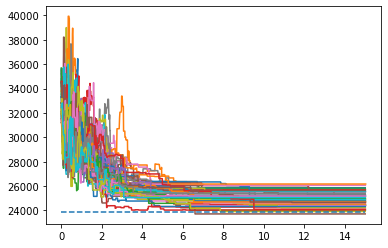

In [19]:
#multi-start
results=[]
distances=[]
for i in range(50):
    result=solve()
    distance=evaluate(result,0)
    results.append(result)
    distances.append(distance)
ind=distances.index(min(distances))
plt.plot([0,15],[23916,23916],linestyle='dashed')
print(results[ind])
print(min(distances))
